In [141]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt

In [142]:
#create training data

In [143]:
folder = "./bmw10_release/bmw10_ims/"

Npixels = 25
Nchannels = 3

cars = []

for d in os.listdir(folder):
    for f in os.listdir(folder+d):
        img = Image.open(folder+d+'/'+f)
        
        img = img.resize((Npixels, Npixels))
        
        cars.append(np.asarray(img))
        
cars = np.asarray(cars)
print cars.shape

NUM_CARS = cars.shape[0]

(512, 25, 25, 3)


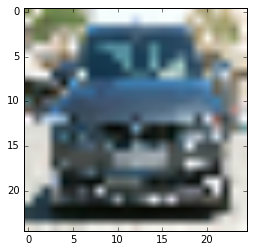

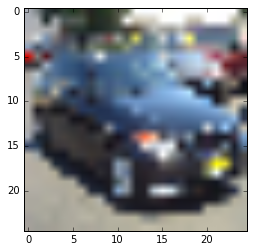

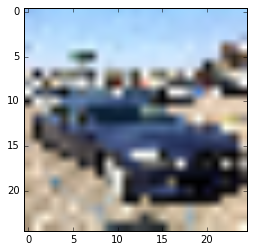

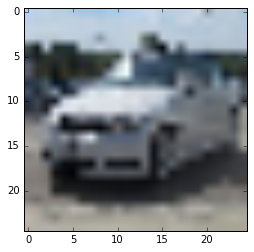

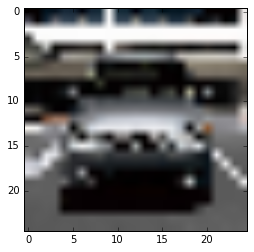

In [144]:
#plot some random images
Num_images_to_plot = 5
for i in range(0,Num_images_to_plot):
    index = np.random.randint(NUM_CARS)
    
    plt.imshow(cars[index,:])
    plt.show()

In [145]:
#normalize data

In [146]:
means = np.mean(cars, axis=(0,1,2))
stdevs = np.std(cars,axis=(0,1,2))

print means
print stdevs

cars_norm = (cars-means)/stdevs

print np.mean(cars_norm, axis=(0,1,2))
print np.std(cars_norm,axis=(0,1,2))

[ 116.94784687  117.20950312  115.99665312]
[ 72.07456184  71.47683711  73.89948193]
[  8.69663890e-16  -1.23780049e-15   1.62429514e-15]
[ 1.  1.  1.]


In [147]:
#tensorflow utility functions
def conv2d_3x3(x, Nchannels=3, Nfilters=32, std=0.01, padding="VALID"):
    
    w = tf.random_normal(shape=(3,3, Nchannels, Nfilters), stddev=std)
    b = tf.Variable(tf.constant(std, shape=[Nfilters]))
    
    out = tf.nn.conv2d(x, w, [1,1,1,1], padding=padding)
    out = tf.nn.bias_add(out, b)
    out = tf.nn.relu(out)
    
    return (out, w,b)

def deconv2d_3x3(x, outshape, out_channels=3, Nfilters=32, std=0.01, padding="VALID"):


    w = tf.random_normal(shape=(3,3, out_channels, Nfilters), stddev=std)
    b = tf.Variable(tf.constant(std, shape=[out_channels]))
    
    out = tf.nn.conv2d_transpose(x, w, outshape, [1,1,1,1], padding=padding)
    out = tf.nn.bias_add(out, b)
    out = tf.nn.relu(out)
    
    return (out, w,b)

def fc(x, insize, outsize, std=0.01):
    
    w = tf.Variable(tf.random_normal([insize, outsize], stddev=std))
    b = tf.Variable(tf.constant(std, shape=[outsize]))
    
    out = tf.matmul(x,w)+b
    
    return (out,w,b)

In [148]:
#define network structure
NBATCH = 100
W_init = 0.01
NOISE_DIM = 50
G_Nunits1 = 500


In [149]:
x = tf.placeholder(tf.float32, shape=(NBATCH,Npixels,Npixels,Nchannels))
z = tf.placeholder(tf.float32, shape=(NBATCH,NOISE_DIM))

In [150]:
#generator network

In [151]:
G_hidden1, G_w1, G_b1 = fc(z, NOISE_DIM, G_Nunits1, std=W_init)
G_hidden1 = tf.nn.relu(G_hidden1)

G_out, G_w2, G_b2 = fc(G_hidden1, G_Nunits1, Npixels*Npixels*Nchannels)
G_out = tf.reshape(G_out, shape=(NBATCH,Npixels,Npixels,Nchannels))

In [152]:
#Discriminator network
Nfilters = 32
Conv_Shape = 3
strides = [1,1,1,1]
p = 0.5

In [153]:
D_w1 = tf.Variable(
    tf.random_normal(shape=(Conv_Shape,Conv_Shape,Nchannels,Nfilters),
                    stddev=W_init
                    )
)

D_b1 = tf.Variable(
    tf.zeros(shape=[Nfilters])
)

D_w2 = tf.Variable(
    tf.random_normal(shape=(Conv_Shape,Conv_Shape,Nfilters,Nfilters),
                    stddev=W_init
                    )
)

D_b2 = tf.Variable(
    tf.zeros(shape=[Nfilters])
)

D_w3 = tf.Variable(
    tf.random_normal(shape=(Nfilters*Npixels**2,1),
                    stddev=W_init
                    )
)

D_b3 = tf.Variable(
    tf.zeros(shape=(1,1))
)

In [154]:
#pass real data through discriminator
def Pass_through_discriminator(x_in):
    D_real_out1 = tf.nn.conv2d(x_in, D_w1, strides, padding="SAME")
    D_real_out1 = tf.nn.bias_add(D_real_out1, D_b1)
    D_real_out1 = tf.nn.relu(D_real_out1)
    D_real_out1 = tf.nn.dropout(D_real_out1, keep_prob=p)
    
    D_real_out2 = tf.nn.conv2d(D_real_out1, D_w2, strides, padding="SAME")
    D_real_out2 = tf.nn.bias_add(D_real_out2, D_b2)
    D_real_out2 = tf.nn.relu(D_real_out2)
    D_real_out2 = tf.nn.dropout(D_real_out2, keep_prob=p)

    D_real_out3 = tf.reshape(D_real_out2,[NBATCH,-1])
    D_real_out3 = tf.matmul(D_real_out3,D_w3)+D_b3
    D_real_out3 = tf.nn.sigmoid(D_real_out3)
    
    return D_real_out3

In [155]:
real_out = Pass_through_discriminator(x)

fake_out = Pass_through_discriminator(G_out)

In [156]:
#loss functions

In [157]:
D_loss = -tf.reduce_mean(tf.log(real_out)) -\
tf.reduce_mean(tf.log(1-fake_out))

G_loss1 = -tf.reduce_mean(tf.log(fake_out))

G_loss2 = tf.reduce_mean(tf.log(1-fake_out))

In [158]:
#set up optimization
lrG = 5e-3
lrD = 2e-5

In [159]:
optG = tf.train.AdamOptimizer(lrG)
optD = tf.train.AdamOptimizer(lrD)
D_train = optD.minimize(D_loss, var_list=[D_w1,D_b1,D_w2,D_b2,D_w3,D_b3])

G_train1 = optG.minimize(G_loss1, var_list=[G_w1,G_b1,G_w2,G_b2])

G_train2 = optG.minimize(G_loss2, var_list=[G_w1,G_b1,G_w2,G_b2])

In [160]:
#set up session and initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [161]:
#set up training loop
Niter1 = 1000
Niter2 = 1000
kd = 1
kg = 1
print_step = 100

def get_batch(xdata, nbatch):
    N = xdata.shape[0]
    inds = np.random.choice(N, size=nbatch, replace=False)
    xret = xdata[inds,:]

    return xret

In [162]:
#some tests
x_batch = get_batch(cars_norm, NBATCH)
z_batch = np.random.rand(NBATCH,NOISE_DIM)

gout = sess.run(G_out, feed_dict={z:z_batch})
print gout.shape
print gout[0,:]

print sess.run(G_loss1, feed_dict={z:z_batch})
print sess.run(G_loss2, feed_dict={z:z_batch})

dout_real = sess.run(real_out, feed_dict={x:x_batch})
dout_fake = sess.run(fake_out, feed_dict={z:z_batch})
print dout_real.shape
print dout_fake.shape
print dout_real
print dout_fake
print sess.run(D_loss, feed_dict={x:x_batch,z:z_batch})

(100, 25, 25, 3)
[[[ 0.01392772  0.01805575  0.00511148]
  [ 0.00848675  0.01075202  0.01360199]
  [ 0.01565852  0.00993985  0.01172003]
  ..., 
  [ 0.0022682   0.0099334   0.01129277]
  [-0.00957292  0.00550274  0.01572381]
  [-0.00108785  0.00782457  0.00466749]]

 [[ 0.01377225  0.02054383 -0.00065187]
  [ 0.01266226  0.00937749  0.01140589]
  [ 0.00219242  0.00852479  0.00563031]
  ..., 
  [-0.00263601  0.01601174 -0.00531585]
  [ 0.01134643  0.01369751  0.01771207]
  [ 0.01505595  0.01896906  0.00679405]]

 [[-0.0051909   0.01424095  0.01629368]
  [ 0.01057239  0.01455525  0.00668857]
  [ 0.00584615  0.01693218  0.00581743]
  ..., 
  [ 0.00502333  0.01447165  0.01902935]
  [ 0.02074559  0.00135641  0.01780371]
  [ 0.00999876  0.00568966  0.00493316]]

 ..., 
 [[ 0.00781976  0.00599174  0.00337828]
  [ 0.01020612  0.0082554   0.00420709]
  [ 0.00259748  0.00849659  0.02356813]
  ..., 
  [ 0.00077111  0.00646483  0.0195087 ]
  [ 0.00714522  0.0222237   0.01334999]
  [ 0.00916761  0.

In [163]:
#training loop 1
for step in xrange(Niter1+1):

    for i in range(0,kd):    
        x_batch = get_batch(cars_norm, NBATCH)
        z_batch = np.random.rand(NBATCH,NOISE_DIM)
        
        sess.run(D_train,feed_dict={x:x_batch,z:z_batch})
    
    for i in range(0,kg):
        z_batch = np.random.rand(NBATCH,NOISE_DIM)
        
        sess.run(G_train1, feed_dict={z:z_batch})
        
    if step % print_step == 0:
        dl=sess.run(D_loss,feed_dict={x:x_batch,z:z_batch})
        gl=sess.run(G_loss1,feed_dict={z:z_batch})

        print "Discriminator loss: ", dl, ", Generator loss: ", gl

Discriminator loss:  1.39259 , Generator loss:  0.689198
Discriminator loss:  1.85046 , Generator loss:  0.688926
Discriminator loss:  1.43191 , Generator loss:  0.685522
Discriminator loss:  1.42423 , Generator loss:  0.678703
Discriminator loss:  1.41973 , Generator loss:  0.678009
Discriminator loss:  1.41373 , Generator loss:  0.679145
Discriminator loss:  1.40995 , Generator loss:  0.680239
Discriminator loss:  1.40598 , Generator loss:  0.681273
Discriminator loss:  1.40416 , Generator loss:  0.679081
Discriminator loss:  1.40191 , Generator loss:  0.675585
Discriminator loss:  1.39747 , Generator loss:  0.673178


In [165]:
#training loop 2
for step in xrange(Niter2+1):
    
    for i in range(0,kd):
        x_batch = get_batch(cars_norm, NBATCH)
        z_batch = np.random.rand(NBATCH,NOISE_DIM)
    
        sess.run(D_train,feed_dict={x:x_batch,z:z_batch})
    
        #dl=sess.run(D_loss,feed_dict={x:x_batch,z:z_batch})
        #gl=sess.run(G_loss2,feed_dict={z:z_batch})
        
        #print "Discriminator loss: ", dl, ", Generator loss: ", gl
    
    for i in range(0,kg):
        z_batch = np.random.rand(NBATCH,NOISE_DIM)
        sess.run(G_train2, feed_dict={z:z_batch})
        
    if step % print_step == 0:
        dl=sess.run(D_loss,feed_dict={x:x_batch,z:z_batch})
        gl=sess.run(G_loss2,feed_dict={z:z_batch})

        print "Discriminator loss: ", dl, ", Generator loss: ", gl

Discriminator loss:  1.39821 , Generator loss:  -0.713766
Discriminator loss:  1.39606 , Generator loss:  -0.716909
Discriminator loss:  1.39448 , Generator loss:  -0.714447
Discriminator loss:  1.39139 , Generator loss:  -0.709343
Discriminator loss:  1.39097 , Generator loss:  -0.70676
Discriminator loss:  1.39083 , Generator loss:  -0.705788
Discriminator loss:  1.38944 , Generator loss:  -0.706875
Discriminator loss:  1.38939 , Generator loss:  -0.705944
Discriminator loss:  1.38937 , Generator loss:  -0.704008
Discriminator loss:  1.38932 , Generator loss:  -0.704368
Discriminator loss:  1.38863 , Generator loss:  -0.706489


In [26]:
#generate some cars

(100, 25, 25, 3)
1.1256


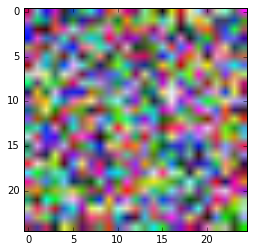

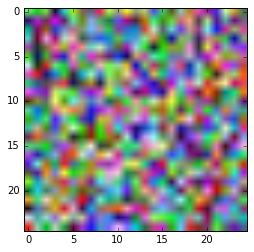

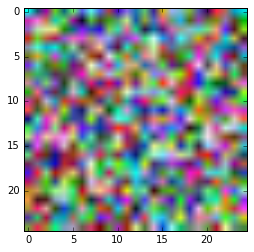

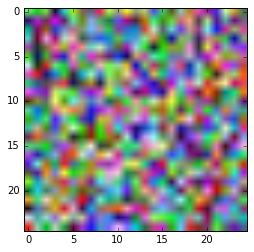

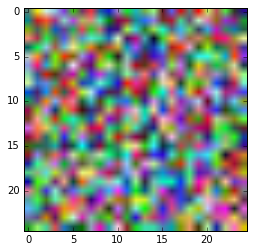

In [166]:
z_batch = np.random.rand(NBATCH,NOISE_DIM)

gen_cars = sess.run(G_out, feed_dict={z:z_batch})
print gen_cars.shape
print np.std(gen_cars)
#plot some random images
Num_images_to_plot = 5
for i in range(0,Num_images_to_plot):
    index = np.random.randint(NBATCH)
    
    plt.imshow((gen_cars[index,:]*stdevs)+means)
    #plt.imshow((gen_cars[index,:]))
    plt.show()